# Temperature Profile
This looks at the temperature profile, to see how it differs from the expected dry adiabat up to the LCL, followed by the moist adiabat.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'precipitation', 'omega', 't_ref', 'dt_tg_diffusion', 
            'dt_tg_convection', 'dt_tg_condensation', 'tdt_rad', 'klzbs', 'ucomp', 'vcomp', 'flux_lhe']  
# var_keep = ['temp', 'sphum', 'height', 't_surf', 'precipitation', 'omega']
# Load dataset
tau_lw_ref = 1
exp_dir = 'aquaplanet/temp_tendency/'
# exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", "k=1_5"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []

use_time_start = 360*2
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/joshduffield/Documents/StAndrews/Isca/isca_output/aquaplanet/temp_tendency/k=1'

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [115]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [116]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
# use_time_start = 0      # because little data

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 
use_summer = False      # if true, will set ds will only contain summer months. Do this outside tropics

ds = []  # need both all and summer day dataset
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i]
        if use_summer:
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds += [ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))]
        pbar.update(1)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 2/2 [00:00<00:00, 17.16it/s]


In [117]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40  # should be 40, but saving memory
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

# lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
lat_use_ind = np.where((ds[0].lat <= lat_max) & (ds[0].lat >= lat_min))[0]      # just NH to save memory
ds = [ds[i].isel(lat=lat_use_ind).load() for i in range(n_exp)]
n_lat = ds[0].lat.shape[0]
n_pressure = ds[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds[0].lat))     # latitude area weighting is just the cosine

## Hottest Day in Tropics

Here I take a single day, which is the hottest day in the tropics, and look at it in detail, to see why it deviates from the temperature profile we expect if it was convectively neutral.

In [118]:
max_surf_temp_ind = ds[0].temp[-1].argmax(dim=['lat', 'lon_time'])
# max_surf_temp_ind['lat'] = 0
# max_surf_temp_ind['lon_time'] = 9421
ds_hot_day = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time']))
ds_hot_day_next = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+1)

In [119]:
p_all = ds_hot_day.pfull * 100
temp_ref_manual, temp_lcl, p_lcl = get_temp_ref(ds_hot_day.temp[-1], p_all[-1], ds_hot_day.sphum[-1], p_all)
temp_moist = moist_profile(float(temp_lcl), float(p_lcl), p_all[p_all<p_lcl])

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:152: UserWarning: Changing temp_start to a float
  warnings.warn('Changing temp_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:155: UserWarning: Changing p_start to a float
  warnings.warn('Changing p_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:158: UserWarning: Changing sphum_start to a float
  warnings.warn('Changing sphum_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:164: UserWarning: Changing p_full to a numpy array
  warnings.warn('Changing p_full to a numpy array')


In [120]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(p_all)), p_all)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

### Temperature Profile

Here we show that in the free troposphere, the simulated temperature (blue line) is lower than the reference temperature profile that convection acts to relax it to (orange solid line).

The dotted orange line is my attempt at computing the reference temperature profile offline, but it is slightly different. One reason is that the starting temperature of ascent is larger.

The green line shows the moist adiabat, and is only shown above the LCL. Again it differs from the temperature profile, that convection is relaxing it towards.

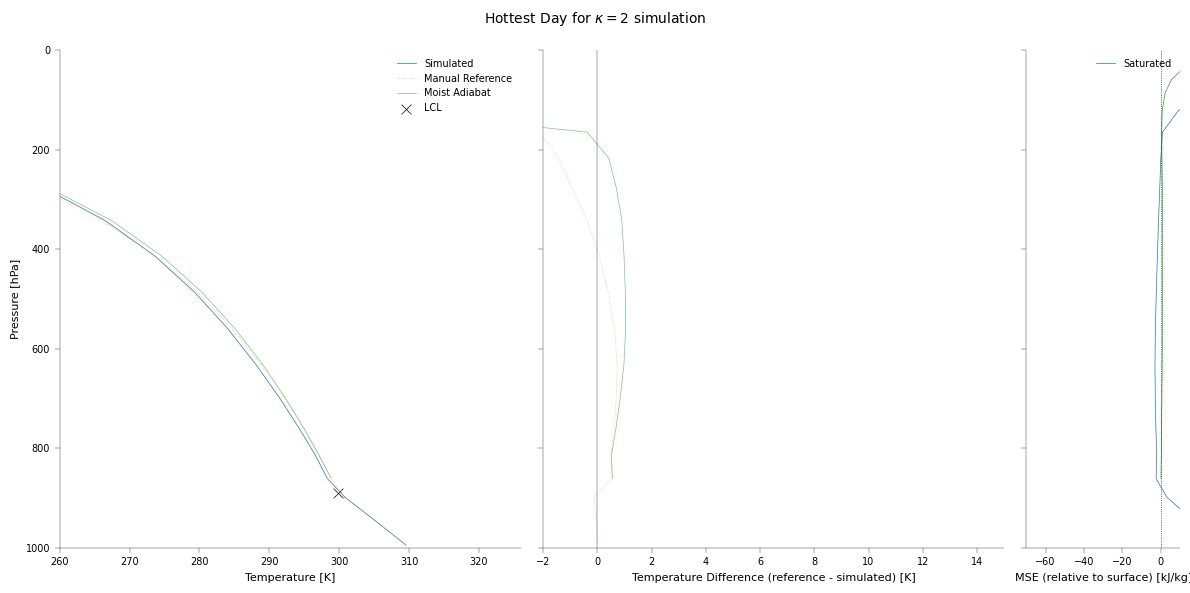

In [121]:
fig, ax = plt.subplots(1, 3, figsize=(12,6), gridspec_kw={'width_ratios': [3, 3, 1]}, sharey=True)
ax[0].plot(ds_hot_day.temp, p_all/100, color=default_colors[0], label='Simulated')
try:
    ax[0].plot(ds_hot_day.t_ref, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
    ax[1].plot(ds_hot_day.t_ref - ds_hot_day.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
    ax[2].plot(moist_static_energy(ds_hot_day.t_ref, sphum_sat(ds_hot_day.t_ref, p_all) - 
                                   moist_static_energy(ds_hot_day.temp[-1], ds_hot_day.sphum[-1], ds_hot_day.height[-1]), ds_hot_day.height), 
               p_all/100, color=default_colors[1])
except AttributeError:
    pass
ax[0].plot(temp_ref_manual, p_all/100, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[0].plot(temp_moist, p_all[p_all<p_lcl]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[0].scatter(temp_lcl, p_lcl/100, color='k', marker='x', s=50, label='LCL')
try:    
    ax[0].hlines(lzb(ds_hot_day.klzbs)/100, 210, 310, color='k', lw=ax_linewidth)
    ax[1].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], -4, 4, color='k', lw=ax_linewidth)
    ax[2].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], 300, 400, color='k', lw=ax_linewidth)
except AttributeError:
    pass
ax[0].set_xlim(260, 326)
ax[0].legend()
ax[0].set_xlabel('Temperature [K]')

ax[1].plot(temp_ref_manual - ds_hot_day.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[1].plot(temp_moist - ds_hot_day.temp[p_all<p_lcl], p_all[p_all<p_lcl]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].set_xlim(-2,15)
ax[1].set_xlabel('Temperature Difference (reference - simulated) [K]')


ax[2].plot(moist_static_energy(ds_hot_day.temp, sphum_sat(ds_hot_day.temp, p_all), ds_hot_day.height) - 
           moist_static_energy(ds_hot_day.temp[-1], ds_hot_day.sphum[-1], ds_hot_day.height[-1]), p_all/100, color=default_colors[0],
           label='Saturated')
ax[2].plot(moist_static_energy(temp_moist, sphum_sat(temp_moist, p_all[p_all<p_lcl]), ds_hot_day.height[p_all<p_lcl]) - 
                               moist_static_energy(ds_hot_day.temp[-1], ds_hot_day.sphum[-1], ds_hot_day.height[-1]), p_all[p_all<p_lcl]/100,
           color=default_colors[2])
ax[2].vlines(0, 1000, 0, color='k', linestyle=':')
# ax[2].set_xlim(330, 350)
ax[2].set_xlim(-70, 10)
ax[2].set_xlabel('MSE (relative to surface) [kJ/kg]')
ax[2].legend()

ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f'Hottest Day for $\kappa={tau_lw[0]}$ simulation', fontsize=10)
plt.tight_layout()

### Temperature Tendency

The left plot shows that the reference temperature is higher (lower) than the simulated above (below) the LCL.

The middle plot shows the temperature tendencies on the hottest day. In particular, there is a strong cooling due to vertical diffusion at around 750hPa.

The right plot is just there to show that there is strong ascent throughout the troposphere on this day.

AttributeError: 'Dataset' object has no attribute 't_ref'

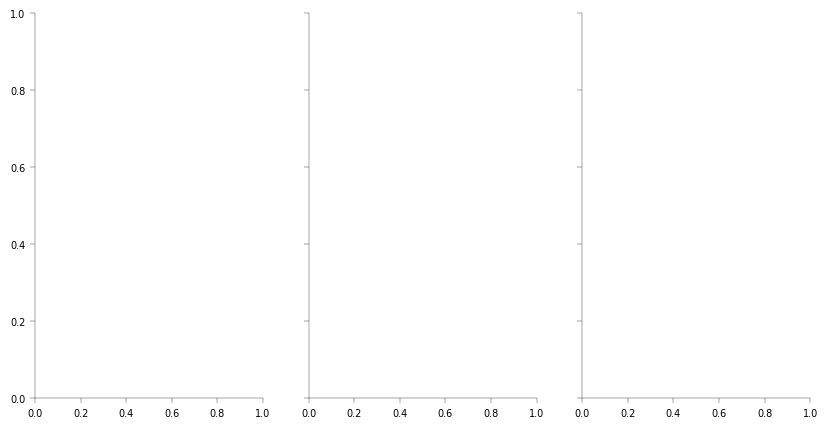

In [122]:
n_day_seconds =  24 * 60**2
fig, ax = plt.subplots(1,3, figsize=(10, 5), sharey=True)
ax[0].plot(ds_hot_day.t_ref - ds_hot_day.temp, p_all/100, color=default_colors[1], alpha=0.6)
ax[0].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
ax[0].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], -4, 4, color='k', lw=ax_linewidth, alpha=0.5)
ax[0].scatter(temp_lcl, p_lcl/100, color='k', marker='x', s=50)
ax[0].set_xlim(-4, 4)
ax[0].set_xlabel('Temperature Difference (reference - simulated) [K]')

ax[1].plot(ds_hot_day.dt_tg_diffusion * n_day_seconds, p_all/100, label='Vertical diffusion')
ax[1].plot(ds_hot_day.dt_tg_condensation * n_day_seconds, p_all/100, label='Condensation')
ax[1].plot(ds_hot_day.dt_tg_convection * n_day_seconds, p_all/100, label='Convection')
try:
    ax[1].plot(ds_hot_day.tdt_rad * n_day_seconds, p_all/100, label='Radiation')
    ax[1].plot((ds_hot_day.dt_tg_convection + ds_hot_day.dt_tg_condensation + ds_hot_day.dt_tg_diffusion + ds_hot_day.tdt_rad) * n_day_seconds, 
               p_all/100, label='Net', color='k', linestyle=':')
except AttributeError:
    ax[1].plot((ds_hot_day.dt_tg_convection + ds_hot_day.dt_tg_condensation + ds_hot_day.dt_tg_diffusion) * n_day_seconds, 
               p_all/100, label='Net', color='k', linestyle=':')
ax[1].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], -30, 30, color='k', lw=ax_linewidth, alpha=0.5, label='LCL')
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
ax[1].set_xlim(-30, 30)
ax[1].set_xlabel('Temperature tendency [K/day]')
ax[1].legend()

# ax[0].set_xlim(270, 290)
ax[2].plot(ds_hot_day.omega, p_all/100)
ax[2].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], -0.35, 0.05, color='k', lw=ax_linewidth, alpha=0.5, label='LCL')
ax[2].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
ax[2].set_xlim(-0.35, 0.05)
ax[2].set_xlabel('$\omega$ [Pa/s]')

ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f'Hottest Day for $\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$)', fontsize=10)
plt.tight_layout()

### Days preceeding and after the hottest day
#### Surface
In these plots, the thick lines at $p=1000hPa$ show the surface temperatures.

Here, we see that prior to the hottest day, the surface temperature starts to decrease, but there is a lag in the atmosphere, so it is still increasing.

After the hottest day, both surface and near-surface temperatures decrease.

In [ ]:
n_days_prior = 4
color_seq = plt.cm.jet(np.linspace(0,1,n_days_prior+1))
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])-(n_days_prior-i))
    # ax[0].plot(ds_use.t_ref, p_all/100, color=color_seq[i])
    ax[0].plot(ds_use.temp, p_all/100, color=color_seq[i], label=f'{-(n_days_prior-i)}')
    ax[0].scatter(ds_use.t_surf, 1000, color=color_seq[i], marker='|', s=300, lw=3)
    # ax[0].plot(ds_use.t_ref, p_all/100, color=color_seq[i], linestyle=':')
    # temp_ref_manual_use, temp_lcl_use, p_lcl_use = get_temp_ref(ds_use.temp[-1], p_all[-1], ds_use.sphum[-1], p_all)
    # ax[0].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+n_days_prior-i)
    # ax[1].plot(ds_use.t_ref - ds_hot_day.t_ref, p_all/100, color=color_seq[i])
    ax[1].plot(ds_use.temp, p_all/100, color=color_seq[i], label=f'{n_days_prior-i}')
    ax[1].scatter(ds_use.t_surf, 1000, color=color_seq[i], marker='|', s=300, lw=3)
    # ax[1].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
ax[0].legend(title='Time relative to\nhottest day [days]')
ax[1].legend(title='Time relative to\nhottest day [days]')
ax[0].invert_yaxis()
ax[0].set_xlim(285, 306)
ax[0].set_ylim(1000, 770)
fig.supxlabel('Temperature [K]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]')
plt.tight_layout()

#### Temperature profile relative to convective reference profile
Here I plot the temperature profiles relative to that of the hottest day. The dotted lines show the reference profiles. The thick lines at $p=1000hPa$ show the surface temperatures relative to the lowest atmospheric level temperature of the hottest day.

Here, we see that 4 days prior to the hottest day, the temperature profile is almost exactly the convectively neutral one, but soon starts to deviate.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])-(n_days_prior-i))
    ax[0].plot(ds_use.temp - ds_hot_day.temp, p_all/100, color=color_seq[i], label=f'{-(n_days_prior-i)}')
    ax[0].plot(ds_use.t_ref - ds_hot_day.temp, p_all/100, color=color_seq[i], linestyle=':', alpha=0.6)
    ax[0].scatter(ds_use.t_surf - ds_hot_day.temp[-1], 1000, color=color_seq[i], marker='|', s=300, lw=3)
    # temp_ref_manual_use, temp_lcl_use, p_lcl_use = get_temp_ref(ds_use.temp[-1], p_all[-1], ds_use.sphum[-1], p_all)
    # ax[0].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+n_days_prior-i)
    ax[1].plot(ds_use.temp - ds_hot_day.temp, p_all/100, color=color_seq[i], label=f'{n_days_prior-i}')
    ax[1].plot(ds_use.t_ref - ds_hot_day.temp, p_all/100, color=color_seq[i], linestyle=':', alpha=0.6)
    ax[1].scatter(ds_use.t_surf - ds_hot_day.temp[-1], 1000, color=color_seq[i], marker='|', s=300, lw=3)
    # ax[1].scatter(ds_use.t_surf - ds_hot_day.t_surf, 1000, color=color_seq[i], marker='x', s=50)
    # ax[1].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
ax[0].invert_yaxis()
ax[0].set_ylim(1000, 200)
ax[0].legend(title='Time relative to\nhottest day [days]')
ax[1].legend(title='Time relative to\nhottest day [days]')
fig.supxlabel('Temperature relative to hottest day [K]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]')
plt.tight_layout()
# fig.savefig(f"/Users/joshduffield/Desktop/temp_rel.jpeg",
#                     dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

#### Vertical wind speed, $\omega$
Here, we see than there is a transition from descent to ascent in the days proceeding the hottest day, and that the hottest day has the largest ascent.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])-(n_days_prior-i))
    ax[0].plot(ds_use.omega, p_all/100, color=color_seq[i], label=f'{-(n_days_prior-i)}')
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+n_days_prior-i)
    ax[1].plot(ds_use.omega, p_all/100, color=color_seq[i], label=f'{n_days_prior-i}')
    # temp_ref_manual_use, temp_lcl_use, p_lcl_use = get_temp_ref(ds_use.temp[-1], p_all[-1], ds_use.sphum[-1], p_all)
    # ax[0].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
ax[0].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[0].invert_yaxis()
ax[0].legend(title='Time relative to\nhottest day [days]')
ax[1].legend(title='Time relative to\nhottest day [days]')
ax[0].set_ylim(1000, 200)
fig.supxlabel('$\omega$ [Pa/s]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]')
plt.tight_layout()

#### Temperature Tendency
This shows how the net (solid lines) and vertical diffusion (dotted) vary before and after the hottest day.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])-(n_days_prior-i))
    ax[0].plot((ds_use.dt_tg_diffusion+ds_use.dt_tg_convection+ds_use.dt_tg_condensation + ds_hot_day.tdt_rad) * n_day_seconds, p_all/100, 
           color=color_seq[i], label=f'{-(n_days_prior-i)}')
    ax[0].plot(ds_use.dt_tg_diffusion * n_day_seconds, p_all/100, color=color_seq[i], linestyle=':', alpha=0.6)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+n_days_prior-i)
    ax[1].plot((ds_use.dt_tg_diffusion+ds_use.dt_tg_convection+ds_use.dt_tg_condensation + ds_hot_day.tdt_rad) * n_day_seconds, p_all/100, 
           color=color_seq[i], label=f'{n_days_prior-i}')
    ax[1].plot(ds_use.dt_tg_diffusion * n_day_seconds, p_all/100, color=color_seq[i], linestyle=':', alpha=0.6)
ax[0].invert_yaxis()
ax[0].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[0].legend(title='Time relative to\nhottest day [days]')
ax[1].legend(title='Time relative to\nhottest day [days]')
ax[0].set_ylim(1000, 200)
ax[0].set_ylabel('Pressure [hPa]')
fig.supxlabel('Temperature tendency [K/day]', fontsize=8)
plt.tight_layout()
# fig.savefig(f"/Users/joshduffield/Desktop/temp_tend.jpeg",
#                     dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Scatter Plot of specific humidity vs temperature

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# #color by latitude
# ax[0].scatter(ds[0].temp[-1], ds[0].sphum[-1], alpha=0.01, 
#               c=np.abs(ds[0].lat).where(ds[0].temp[-1]<np.inf), vmin=0, vmax=20)
# ax[1].scatter(ds[1].temp[-1]-ds[0].temp[-1], ds[1].sphum[-1]-ds[0].sphum[-1], alpha=0.01, 
#               c=np.abs(ds[0].lat).where(ds[0].temp[-1]<np.inf), vmin=0, vmax=20)
# im = ax[1].scatter(0, 0, c=5, s=0, vmin=0, vmax=20)       # add a marker you can't see, for the colorbar
# plt.colorbar(im, label='Absolute latitude [deg]')

# #color by k=1 temperature
ax[0].scatter(ds[0].temp[-1], ds[0].sphum[-1], alpha=0.01)
ax[1].scatter(ds[1].temp[-1]-ds[0].temp[-1], ds[1].sphum[-1]-ds[0].sphum[-1], alpha=0.01, 
              c=ds[0].temp[-1], vmin=280, vmax=300)
im = ax[1].scatter(0, 0, c=5, s=0, vmin=280, vmax=300)       # add a marker you can't see, for the colorbar
plt.colorbar(im, label=f'$\kappa={tau_lw[0]}$ temperature [K]')

fig.supxlabel('Near-surface Temperature [K]', fontsize=8)
ax[0].set_ylabel('Near-surface Specific Humidity [kg/kg]')
ax[0].set_title(f'Reference: $\kappa={tau_lw[0]}$')
ax[1].set_title(f'Difference: $(\kappa={tau_lw[1]}) - (\kappa={tau_lw[0]})$')
plt.tight_layout()

## Influence of $\omega$
From the above plots, it was noticeable that the hottest day had a very negative $\omega$. 

Below, I show that there is a strong correlation for how negative $\omega$ is, and by how much the simulated temperature profile differs from the convective reference profile.

I.e. the more ascent there is, the less influence convection has on the temperature profile.

In [ ]:
# See if deviation from reference profile is related to fast ascent
pressure_lzb = [lzb(ds[i].klzbs.where(ds[i].klzbs>=1))/100 for i in range(n_exp)]           # pressure of LZB
# highest altitude reached by convection is where temperature tendency is first non zero due to convection
pressure_min_conv_dt_tg_thresh = 0.01/n_day_seconds     # have temp tendency larger than 0.01K/day
pressure_min_conv = [ds[i].pfull.where(np.abs(ds[i].dt_tg_convection)>pressure_min_conv_dt_tg_thresh).min(dim='pfull') for i in range(n_exp)] 
# p_use = np.logical_and(p_all > 200 * 100, p_all < 900 * 100)  # Avoid surface and far above LNB

# If LZB at lower altitude, replace conv pressure with this
omega_max = []
thresh_p_use_upper = 900        # ignore close to surface
for i in range(n_exp):
    pressure_min_conv[i].values = np.asarray([pressure_lzb[i], pressure_min_conv[i]]).max(axis=0)  
    p_use = np.logical_and(ds[i].pfull>=pressure_min_conv[i], ds[i].pfull<thresh_p_use_upper)
    omega_max += [ds[i].omega.where(p_use).min(dim=['pfull']) for i in range(n_exp)]
    # Calculate max variables only at reference simulation
    if i == 0:
        ref_temp_dev_max = (ds[0].t_ref - ds[0].temp).where(p_use).max(dim=['pfull'])
        diffusion_tendancy_max = ds[0].dt_tg_diffusion.where(p_use).min(dim=['pfull'])
        mse_dev_max = (moist_static_energy(ds[0].temp[-1], ds[0].sphum[-1], ds[0].height[-1]) - 
               moist_static_energy(ds[0].temp, sphum_sat(ds[0].temp, p_all), ds[0].height)).where(p_use)
        mse_dev_max = mse_dev_max.max(dim=['pfull'])*1000/c_p       # convert into Kelvin

        mse_dev_max_ref = (moist_static_energy(ds[0].temp[-1], ds[0].sphum[-1], ds[0].height[-1]) - 
                   moist_static_energy(ds[0].t_ref, sphum_sat(ds[0].t_ref, p_all), ds[0].height)).where(p_use)
        mse_dev_max_ref = mse_dev_max_ref.max(dim=['pfull'])*1000/c_p

In [ ]:
mse_dev_thresh = 9
fig, ax = plt.subplots(1, 3, figsize=(13, 5))
p_conv_use_thresh = 900             # only show days with min convective pressure less than this
p_conv_use = pressure_min_conv[0] < p_conv_use_thresh
lat_ind_scatter = None            # combine all latitudes
# lat_ind_scatter = -1
if lat_ind_scatter is not None:
    p_conv_use = np.logical_and(p_conv_use, np.abs(ref_temp_dev_max.lat)==np.unique(np.abs(ref_temp_dev_max.lat))[lat_ind_scatter])

# Color by convective pressure
# ax[0].scatter(ref_temp_dev_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# ax[1].scatter(omega_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# ax[2].scatter(omega_max.where(p_conv_use), ref_temp_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# im = ax[2].scatter(0, 0, c=500, s=0, vmin=200, vmax=p_conv_use_thresh)       # add a marker you can't see, for the colorbar
# plt.colorbar(im, label='Min Convective Pressure [hPa]')

# Color by latitude
# ax[0].scatter(ref_temp_dev_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# ax[1].scatter(omega_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# ax[2].scatter(omega_max.where(p_conv_use), ref_temp_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# im = ax[2].scatter(0, 0, c=5, s=0, vmin=0, vmax=20)       # add a marker you can't see, for the colorbar
# plt.colorbar(im, label='Absolute latitude [deg]')

# Color by difference between profile and convective profile
ax[0].scatter(ref_temp_dev_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
              c=(mse_dev_max-mse_dev_max_ref).where(p_conv_use), vmin=0, vmax=8)
ax[1].scatter(omega_max[0].where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
              c=(mse_dev_max-mse_dev_max_ref).where(p_conv_use), vmin=0, vmax=8)
ax[2].scatter(omega_max[0].where(p_conv_use), ref_temp_dev_max.where(p_conv_use), alpha=0.1, 
              c=(mse_dev_max-mse_dev_max_ref).where(p_conv_use), vmin=0, vmax=8)
im = ax[2].scatter(0, 0, c=3, s=0, vmin=0, vmax=8)       # add a marker you can't see, for the colorbar
plt.colorbar(im, label='Max MSE Difference -\nMax ref MSE Difference [K]')

ax[0].hlines(mse_dev_thresh, -0.1, 3.4, color='k', lw=ax_linewidth)
ax[1].hlines(mse_dev_thresh, -0.9, 0.1, color='k', lw=ax_linewidth)
ax[0].set_xlabel('Max Temperature Difference \n(reference - simulated) [K]')
ax[0].set_ylabel('Max MSE Difference (surface - saturated) [K]')
ax[1].set_xlabel('Min $\omega$')
ax[1].set_ylabel('Max MSE Difference (surface - saturated) [K]')
ax[2].set_xlabel('Min $\omega$')
ax[2].set_ylabel('Max Temperature Difference \n(reference - simulated) [K]')
ax[0].set_ylim(-10, 15)
ax[1].set_ylim(-10, 15)
ax[0].set_xlim(-0.2, 3.4)
ax[2].set_ylim(-0.2, 3.4)
ax[1].set_xlim(-0.9, 0.2)
ax[2].set_xlim(-0.9, 0.2)
# fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; 200hPa-900hPa)', fontsize=10)
if lat_ind_scatter is None:
    fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; Min Convection Pressure-900hPa)', fontsize=10)
else:
    fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|={round(np.unique(np.abs(ref_temp_dev_max.lat))[lat_ind_scatter], 1)}\degree$; '
                 f'Min Convection Pressure-900hPa)', fontsize=10)
plt.tight_layout()

In [ ]:
# # Plot only days with large MSE deviation
# fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# ax.scatter(omega_max[0].where(mse_dev_max>mse_dev_thresh), ref_temp_dev_max.where(mse_dev_max>mse_dev_thresh), 
#            c=pressure_min_conv[0].where(mse_dev_max>mse_dev_thresh), alpha=0.1, vmin=200, vmax=900)
# im = ax.scatter(0, 0, c=500, s=0, vmin=200, vmax=900)
# plt.colorbar(im, label='Min Convective Pressure [hPa]')
# ax.set_xlabel('Min $\omega$')
# ax.set_ylabel('Max Temperature Difference \n(reference - simulated) [K]')
# fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; 200-900hPa)\nMax MSE Difference > {mse_dev_thresh}K', fontsize=10)
# plt.tight_layout()

### Vertical Diffusion Tendency
Below, I do a scatter plot of vertical diffusion tendency vs temperature difference to convective profile. The idea is that maybe a large vertical diffusion term is responsible for a deviation from the convective profile. But the correlation is much less strong than with $\omega$, so this doesn't appear to be the case.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(omega_max[0], ref_temp_dev_max, alpha=0.01)
ax[1].scatter(diffusion_tendancy_max * 24 * 60 ** 2, ref_temp_dev_max, alpha=0.01)
ax[0].set_ylabel('Max Temperature Difference between 200hPa - 900hPa\n(reference - simulated) [K]')
ax[0].set_xlabel('Min $\omega$ between 200hPa - 900hPa [Pa/s]')
ax[1].set_xlabel('Min vertical diffusion tendency between 200hPa - 900hPa [K/day]')
fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$)', fontsize=10)
plt.tight_layout()

### Convective altitude reached
Below I show that the altitude that convection reaches increases (min pressure decreases) with near-surface temperature and latitude.

In [ ]:
# Show hottest days have convection that reaches a higher altitude (lower pressure)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(pressure_min_conv[0], ds[0].temp[-1], c=np.abs(ds[0].lat.where(ds[0].temp[-1]>0)), alpha=0.01, vmin=lat_min, vmax=lat_max)
im = ax.scatter(250, 300, c=5, s=0, vmin=lat_min, vmax=lat_max)       # add a marker you can't see, for the colorbar
plt.colorbar(im, label='Absolute latitude [deg]')
ax.set_xlabel('Min Convective Pressure [hPa]')
ax.set_ylabel('Near-surface Temperature [K]')
plt.tight_layout()

### Influence of $\omega$ on MSE deviation from convective neutral profile

Below, I show that for the MSE difference to be greater than the ref profile MSE difference (i.e. for the actual profile to not be the one that convection is relaxing it towards), a large ascent is required.

In [ ]:
# Show that it is not really possible to differ from convectively neutral profile without large ascent
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(omega_max[0], mse_dev_max-mse_dev_max_ref, alpha=0.01)
# ax.scatter(ds[0].ucomp[-1], mse_dev_max-mse_dev_max_ref, alpha=0.01)
ax.set_xlabel('Min $\omega$')
ax.set_ylabel('Max MSE Difference -\nMax ref MSE Difference [K]')
fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; Min Convection Pressure-900hPa)', fontsize=10)
plt.tight_layout()

### LZB vs Min Convective Pressure
This just shows that with my new definition of min convective pressure, the LZB pressure is always lower (at higher altitude).

In [ ]:
# Show that level of neutral buoyancy (LZB) is always at higher altitude (lower pressure) than level than convection reaches.
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(pressure_lzb[0], pressure_min_conv[0])
ax.set_xlabel('LZB Pressure [hPa]')
ax.set_ylabel('Min Convective Pressure [hPa]')
plt.tight_layout()

### Saturation MSE Deviation at 600hPa
This repeats the initial wind scatter plot, but only considers the MSE deviation from the surface at 600hPa, as to better understand what is causing $\lambda_1 \neq 1$ in the temperature extreme theory.

Only days for which convection reaches a level of 500hPa are considered (i.e. free troposphere level must be between LCL and LNB, so try to ensure this.

In [ ]:
p_ft = 600

ref_temp_dev_ft = [(ds[i].t_ref - ds[i].temp).sel(pfull=p_ft, method='nearest') for i in range(n_exp)]
mse_dev_ft = [(moist_static_energy(ds[i].temp[-1], ds[i].sphum[-1], ds[i].height[-1]) - 
               moist_static_energy(ds[i].temp, sphum_sat(ds[i].temp, p_all), ds[i].height)).sel(pfull=p_ft, method='nearest')*1000/c_p 
              for i in range(n_exp)]        # convert into Kelvin 

mse_dev_ft_ref = [(moist_static_energy(ds[i].temp[-1], ds[i].sphum[-1], ds[i].height[-1]) - 
                   moist_static_energy(ds[i].t_ref, sphum_sat(ds[i].t_ref, p_all), ds[i].height)).sel(pfull=p_ft, method='nearest')*1000/c_p 
                  for i in range(n_exp)]
p_ft_actual = round(float(mse_dev_ft_ref[0].pfull), 1)

In [ ]:
# plt.scatter(ds[0].klzbs, mse_dev_ft[0], alpha=0.01)

In [ ]:
ind_plot = 0        # which experiment to plot
fig, ax = plt.subplots(1, 3, figsize=(13, 5))
p_conv_use_thresh_ft = 600             # only show days with min convective pressure less than this
p_conv_use_ft = [pressure_min_conv[i] < p_conv_use_thresh_ft for i in range(n_exp)]
# p_conv_use_ft = pressure_min_conv[ind_plot] > p_conv_use_thresh_ft

# Color by convective pressure
# ax[0].scatter(ref_temp_dev_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# ax[1].scatter(omega_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# ax[2].scatter(omega_max.where(p_conv_use), ref_temp_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# im = ax[2].scatter(0, 0, c=500, s=0, vmin=200, vmax=p_conv_use_thresh)       # add a marker you can't see, for the colorbar
# plt.colorbar(im, label='Min Convective Pressure [hPa]')

# Color by latitude
# ax[0].scatter(ref_temp_dev_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# ax[1].scatter(omega_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# ax[2].scatter(omega_max.where(p_conv_use), ref_temp_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# im = ax[2].scatter(0, 0, c=5, s=0, vmin=0, vmax=20)       # add a marker you can't see, for the colorbar
# plt.colorbar(im, label='Absolute latitude [deg]')

# Color by difference between profile and convective profile
ax[0].scatter(ref_temp_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), mse_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
              c=(mse_dev_ft[ind_plot]-mse_dev_ft_ref[ind_plot]).where(p_conv_use_ft[ind_plot]), vmin=0, vmax=6.5)
ax[1].scatter(omega_max[ind_plot].where(p_conv_use_ft[ind_plot]), mse_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
              c=(mse_dev_ft[ind_plot]-mse_dev_ft_ref[ind_plot]).where(p_conv_use_ft[ind_plot]), vmin=0, vmax=6.5)
ax[2].scatter(omega_max[ind_plot].where(p_conv_use_ft[ind_plot]), ref_temp_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
              c=(mse_dev_ft[ind_plot]-mse_dev_ft_ref[ind_plot]).where(p_conv_use_ft[ind_plot]), vmin=0, vmax=6.5)
im = ax[2].scatter(0, 0, c=3, s=0, vmin=0, vmax=6.5)       # add a marker you can't see, for the colorbar
plt.colorbar(im, label='MSE Difference -\nref MSE Difference [K]')

# Color by near-surface temperature
# ax[0].scatter(ref_temp_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), mse_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
#               c=ds[ind_plot].temp[-1].where(p_conv_use_ft[ind_plot]), vmin=290 if ind_plot==0 else 295, vmax=300 if ind_plot==0 else 304)
# ax[1].scatter(omega_max[ind_plot].where(p_conv_use_ft[ind_plot]), mse_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
#               c=ds[ind_plot].temp[-1].where(p_conv_use_ft[ind_plot]), vmin=290 if ind_plot==0 else 295, vmax=300 if ind_plot==0 else 304)
# ax[2].scatter(omega_max[ind_plot].where(p_conv_use_ft[ind_plot]), ref_temp_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
#               c=ds[ind_plot].temp[-1].where(p_conv_use_ft[ind_plot]), vmin=290 if ind_plot==0 else 295, vmax=300 if ind_plot==0 else 304)
# # add a marker you can't see, for the colorbar
# im = ax[2].scatter(0, 0, c=3, s=0, vmin=290 if ind_plot==0 else 295, vmax=300 if ind_plot==0 else 304)       
# plt.colorbar(im, label='Near-surface Temperature [K]')

# Color by u wind
# ax[0].scatter(ref_temp_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), mse_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
#               c=ds[ind_plot].ucomp[-1].where(p_conv_use_ft[ind_plot]), vmin=-20, vmax=20, cmap='bwr')
# ax[1].scatter(omega_max[ind_plot].where(p_conv_use_ft[ind_plot]), mse_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
#               c=ds[ind_plot].ucomp[-1].where(p_conv_use_ft[ind_plot]), vmin=-20, vmax=20, cmap='bwr')
# ax[2].scatter(omega_max[ind_plot].where(p_conv_use_ft[ind_plot]), ref_temp_dev_ft[ind_plot].where(p_conv_use_ft[ind_plot]), alpha=0.1, 
#               c=ds[ind_plot].ucomp[-1].where(p_conv_use_ft[ind_plot]), vmin=-20, vmax=20, cmap='bwr')
# # add a marker you can't see, for the colorbar
# im = ax[2].scatter(0, 0, c=3, s=0, vmin=-20, vmax=20, cmap='bwr')       
# plt.colorbar(im, label='Near-surface zonal wind velocity [m/s]')

ax[0].hlines(mse_dev_thresh, -0.1, 3.4, color='k', lw=ax_linewidth)
ax[1].hlines(mse_dev_thresh, -0.9, 0.1, color='k', lw=ax_linewidth)
ax[0].set_xlabel('Temperature Difference \n(reference - simulated) [K]')
ax[0].set_ylabel('MSE Difference (surface - saturated) [K]')
ax[1].set_xlabel('Min $\omega$ (900hPa-Min Convective Pressure)')
ax[1].set_ylabel('MSE Difference (surface - saturated) [K]')
ax[2].set_xlabel('Min $\omega$ (900hPa-Min Convective Pressure)')
ax[2].set_ylabel('Temperature Difference \n(reference - simulated) [K]')
ax[0].set_ylim(-10, 15)
ax[1].set_ylim(-10, 15)
ax[0].set_xlim(-0.2, 3.4)
ax[2].set_ylim(-0.2, 3.4)
ax[1].set_xlim(-0.9, 0.2)
ax[2].set_xlim(-0.9, 0.2)
# fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; 200hPa-900hPa)', fontsize=10)
if lat_ind_scatter is None:
    fig.suptitle(f'$\kappa={tau_lw[ind_plot]}$ simulation ($|\phi|<20\degree$; p={p_ft_actual}hPa)', fontsize=10)
else:
    fig.suptitle(f'$\kappa={tau_lw[ind_plot]}$ simulation '
                 f'($|\phi|={round(np.unique(np.abs(ref_temp_dev_ft[0].lat))[lat_ind_scatter], 1)}\degree$; '
                 f'p={p_ft_actual}hPa)', fontsize=10)
plt.tight_layout()

## $\kappa=1$ vs $\kappa=1.5$
In the plot below, we see that the relationship between MSE difference and $\omega$ changes slightly as we move to a warmer climate.

In [ ]:
def get_linear_fit(x, y):
    # linear fitting for a 2D xarray with nan values
    x = x.to_numpy().flatten()
    y = y.to_numpy().flatten()
    # Needs to be not nan for both
    use = np.logical_and(np.isfinite(x), np.isfinite(y))
    return np.polyfit(x[use], y[use], 1)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13, 5))
# Color by difference between profile and convective profile
for i in range(n_exp):
    ax[0].scatter(ref_temp_dev_ft[i].where(p_conv_use_ft[i]), mse_dev_ft[i].where(p_conv_use_ft[i]), alpha=0.01, 
                  c=default_colors[i])
    ax[1].scatter(omega_max[i].where(p_conv_use_ft[i]), mse_dev_ft[i].where(p_conv_use_ft[i]), alpha=0.01, 
                  c=default_colors[i])    
    ax[2].scatter(omega_max[i].where(p_conv_use_ft[i]), ref_temp_dev_ft[i].where(p_conv_use_ft[i]), alpha=0.01, 
                  c=default_colors[i])
    ax[0].scatter(-1000, -1000, c=default_colors[i], label=tau_lw[i])      # for legend, use opaque spot off screen
    # grad_use, intercept_use = get_linear_fit(ref_temp_dev_ft[i].where(p_conv_use_ft_diff[i]), mse_dev_ft[i].where(p_conv_use_ft_diff[i]))
    # ax[0].plot(np.arange(-1, 4), grad_use * np.arange(-1, 4)+intercept_use, color=default_colors[i])
    # grad_use, intercept_use = get_linear_fit(omega_max[i].where(p_conv_use_ft_diff[i]), mse_dev_ft[i].where(p_conv_use_ft_diff[i]))
    # ax[1].plot(np.arange(-1, 4), grad_use * np.arange(-1, 4)+intercept_use, color=default_colors[i])
    # grad_use, intercept_use = get_linear_fit(omega_max[i].where(p_conv_use_ft_diff[i]), ref_temp_dev_ft[i].where(p_conv_use_ft_diff[i]))
    # ax[2].plot(np.arange(-1, 4), grad_use * np.arange(-1, 4)+intercept_use, color=default_colors[i])

ax[0].set_xlabel('Temperature Difference \n(reference - simulated) [K]')
ax[0].set_ylabel('MSE Difference (surface - saturated) [K]')
ax[1].set_xlabel('Min $\omega$ (900hPa-Min Convective Pressure)')
ax[1].set_ylabel('MSE Difference (surface - saturated) [K]')
ax[2].set_xlabel('Min $\omega$ (900hPa-Min Convective Pressure)')
ax[2].set_ylabel('Temperature Difference \n(reference - simulated) [K]')
ax[0].legend(title='$\kappa$')
ax[0].set_ylim(-10, 15)
ax[1].set_ylim(-10, 15)
ax[0].set_xlim(-0.2, 3.4)
ax[2].set_ylim(-0.2, 3.4)
ax[1].set_xlim(-0.9, 0.2)
ax[2].set_xlim(-0.9, 0.2)
# fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; 200hPa-900hPa)', fontsize=10)
if lat_ind_scatter is None:
    fig.suptitle(f'$|\phi|<20\degree$; p={p_ft_actual}hPa', fontsize=10)
else:
    fig.suptitle(f'$|\phi|={round(np.unique(np.abs(ref_temp_dev_ft[0].lat))[lat_ind_scatter], 1)}\degree$; p={p_ft_actual}hPa', fontsize=10)
plt.tight_layout()

### How much of MSE difference can be explained by difference to reference profile
It seems for days with large $|u|$, a large fraction of the MSE difference can be explained by the profile differing from the reference profile (trend almost follows the red line).

For days with small $|u|$, a very small amount can be explained by the profile differing from the reference profile - for these days, the reference profile must differ from a moist adiabat.

In [ ]:
# plot_var_use = 'diff'
plot_var_use = 'ref'
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for i in range(n_exp):
    # use = mse_dev_ft[i]>0
    use = pressure_min_conv[i]<500
    # ax[i].scatter(mse_dev_ft[i].where(use), 
    #               (mse_dev_ft[i]-mse_dev_ft_ref[i]).where(use) if plot_var_use == 'diff' else mse_dev_ft_ref[i].where(use),
    #               c=ds[i].ucomp[-1].where(use), vmin=-20, vmax=20, alpha=0.01, cmap='bwr')
    # im = ax[i].scatter(-10000, -10000, c=0, vmin=-20, vmax=20, cmap='bwr')
    # ax[i].scatter(mse_dev_ft[i].where(use), 
    #               (mse_dev_ft[i]-mse_dev_ft_ref[i]).where(use) if plot_var_use == 'diff' else mse_dev_ft_ref[i].where(use),
    #               c=omega_max[i].where(use), alpha=0.01, vmin=-0.6, vmax=0)
    # im = ax[i].scatter(-10000, -10000, c=0, vmin=-0.6, vmax=0)
    ax[i].scatter(mse_dev_ft[i].where(use), 
              (mse_dev_ft[i]-mse_dev_ft_ref[i]).where(use) if plot_var_use == 'diff' else mse_dev_ft_ref[i].where(use),
              c=pressure_min_conv[i].where(use), vmin=250, vmax=500, alpha=0.01)
    im = ax[i].scatter(-10000, -10000, c=0, vmin=250, vmax=500)
    
    ax[i].plot(np.arange(-20, 20), np.arange(-20, 20), color='k', lw=ax_linewidth)
    ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
ax[0].set_xlim(-1, 17)
ax[0].set_ylim(-1, 17)
fig.supxlabel(f'MSE Difference (surface - saturated)) [K]', fontsize=8)
if plot_var_use == 'diff':
    ax[0].set_ylabel('MSE Difference - ref MSE Difference [K]')
else:
    ax[0].set_ylabel('ref MSE Difference [K]')
cbar_ax = fig.add_axes([0.49, 0.15, 0.01, 0.7])     # add axes for colorbar
# fig.colorbar(im, cax=cbar_ax, label='$u$ [m/s]', aspect=100, pad=0.01, fraction=0.01)
# fig.colorbar(im, cax=cbar_ax, label='Min $\omega$ (900hPa-Min Convective Pressure) [Pa/s]', aspect=100, pad=0.01, fraction=0.01)
fig.colorbar(im, cax=cbar_ax, label='Min Convective Pressure [hPa]', aspect=100, pad=0.01, fraction=0.01)
fig.suptitle(f'${lat_min}\degree<\phi<{lat_max}\degree$; p={p_ft_actual}hPa', fontsize=10);

Look at how many days are in each cluster - seems most are in the ref MSE Difference $\approx$ 0 one.

In [ ]:
def get_hist_2d(x, y, n_bins=10, bin_lower=None, bin_upper=None):
    # Returns hist counts and center of each bin
    x = x.to_numpy().flatten()
    y = y.to_numpy().flatten()
    use = np.logical_and(np.isfinite(x), np.isfinite(y))
    if bin_lower is None:
        bin_lower = [x[use].min(), y[use].min()]
    if bin_upper is None:
        bin_upper = [x[use].max(), y[use].max()]
    hist_counts, hist_bins_x, hist_bins_y = np.histogram2d(x[use], y[use], bins=n_bins, 
                                                           range=[[bin_lower[i], bin_upper[i]] for i in range(2)])
    return hist_counts, np.convolve(hist_bins_x, np.ones(2)/2, mode='valid'), np.convolve(hist_bins_y, np.ones(2)/2, mode='valid')

In [ ]:
# plot_var_use = 'diff'
plot_var_use = 'ref'
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
hist_bins_use = [0, 0]
for i in range(n_exp):
    # use = p_conv_use_ft[i]
    use = mse_dev_ft[i]>0
    hist_counts_use, hist_bins_use[0], hist_bins_use[1] = get_hist_2d(
        mse_dev_ft[i].where(use), 
        (mse_dev_ft[i]-mse_dev_ft_ref[i]).where(use) if plot_var_use == 'diff' else mse_dev_ft_ref[i].where(use), 
    n_bins=50, bin_lower=[-0.5, -0.5], bin_upper=[10, 10])
    im = ax[i].pcolormesh(hist_bins_use[0], hist_bins_use[1], 100*hist_counts_use.transpose()/np.sum(hist_counts_use), 
                          shading='nearest', vmin=0, vmax=2.3)
    ax[i].plot(np.arange(-20, 20), np.arange(-20, 20), color='r', lw=ax_linewidth)
    ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
ax[0].set_xlim(-0.5, 10)
ax[0].set_ylim(-0.5, 10)
cbar_ax = fig.add_axes([0.49, 0.15, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='% of Days', aspect=100, pad=0.01, fraction=0.01)
if plot_var_use == 'diff':
    ax[0].set_ylabel('MSE Difference - ref MSE Difference [K]')
else:
    ax[0].set_ylabel('ref MSE Difference [K]')
fig.supxlabel(f'MSE Difference (surface - saturated)) [K]', fontsize=8)
fig.suptitle(f'${lat_min}\degree<\phi<{lat_max}\degree$; p={p_ft_actual}hPa', fontsize=10);

### $\omega$ and MSE difference histograms
Below, we see that $\omega$ is lower but MSE difference is larger for the $\kappa=1.5$ simulation.

In [ ]:
def get_hist(x, n_bins=10, bin_lower=None, bin_upper=None):
    # Returns hist counts and center of each bin
    x = x.to_numpy().flatten()
    x = x[np.isfinite(x)]
    if bin_lower is None:
        bin_lower = x.min()
    if bin_upper is None:
        bin_upper = x.max()
    hist_counts, hist_bins = np.histogram(x, n_bins, range=(bin_lower, bin_upper))
    return hist_counts, np.convolve(hist_bins, np.ones(2)/2, mode='valid')

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
n_hist_bins = 30
bin_omega_range = [-0.55, 0.1]
bin_mse_dev_range = [-0.5, 8]

for i in range(n_exp):
    hist_counts_use, hist_bins_use = get_hist(omega_max[i].where(p_conv_use_ft[i]), n_bins=n_hist_bins, 
                                              bin_lower=bin_omega_range[0], bin_upper=bin_omega_range[1])
    ax[0].plot(hist_bins_use, hist_counts_use/np.sum(hist_counts_use), '-o', label=tau_lw[i])
    ax[0].legend(title='$\kappa$')
    ax[0].set_xlabel('Min $\omega$ (900hPa-Min Convective Pressure)')
    ax[0].set_ylabel('Density')
    hist_counts_use, hist_bins_use = get_hist(mse_dev_ft[i].where(p_conv_use_ft[i]), n_bins=n_hist_bins, 
                                              bin_lower=bin_mse_dev_range[0], bin_upper=bin_mse_dev_range[1])
    ax[1].plot(hist_bins_use, hist_counts_use/np.sum(hist_counts_use), '-o')
    ax[1].set_xlabel(f'MSE Difference (surface - {p_ft_actual}hPa saturated)) [K]')
ax[0].set_ylim(0, ax[0].get_ylim()[1])
fig.suptitle(f'Days for which MSE Difference - Min Convective Pressure < {p_ft_actual}hPa',
             fontsize=9)
plt.tight_layout()

### Consider as function of temperature percentile

Below we see that both ascent and MSE difference increase with temperature. $\kappa=1$ also has larger ascent and smaller MSE difference for any given quantile though.

If we plot as function of near-surface temperature though, we see that for any given temperature, $\kappa=1$ has larger ascent and larger MSE difference.

In [ ]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

# mse as function of mse quantile not temp quantile
mse_dev_ft_quant3 = np.zeros((n_exp, n_lat, n_quant))
mse_dev_ft_ref_quant3 = np.zeros((n_exp, n_lat, n_quant))
omega_max_quant3 = np.zeros((n_exp, n_lat, n_quant))
quant3_use_count = np.zeros((n_exp, n_lat, n_quant), dtype=int)

with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        # use = p_conv_use_ft[i]
        use = mse_dev_ft[i] > 0
        use = np.logical_and(use, omega_max[i]<-0.05)
        omega_max_use = omega_max[i].where(use)
        mse_dev_use = mse_dev_ft[i].where(use)
        mse_dev_ref_use = mse_dev_ft_ref[i].where(use)
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds[i].temp[-1, k], quant, 0.5, 0.5)
                omega_max_quant3[i, k, j] = omega_max_use[k, use_ind].mean()
                mse_dev_ft_quant3[i, k, j] = mse_dev_use[k, use_ind].mean()
                mse_dev_ft_ref_quant3[i, k, j] = mse_dev_ref_use[k, use_ind].mean()
                quant3_use_count[i, k, j] = np.isfinite(omega_max_use[k, use_ind]).sum()
                pbar.update(1)

In [ ]:
xaxis_temp_quant = 'quant'
# xaxis_temp_quant = 'temp'
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
for i in range(n_exp):
    if xaxis_temp_quant == 'quant':
        ax[0].plot(quant_plot, np.average(omega_max_quant3[i], axis=0, weights=lat_weights), label=tau_lw[i])
        ax[1].plot(quant_plot, np.average(mse_dev_ft_quant3[i], axis=0, weights=lat_weights), 
                   color=default_colors[i], label='Simulated' if i==0 else None)
        ax[1].plot(quant_plot, np.average(mse_dev_ft_ref_quant3[i], axis=0, weights=lat_weights), linestyle=':',
                   color=default_colors[i], label='Reference' if i==0 else None)
    else:
        ax[0].plot(np.average(ds[i].temp[-1].quantile(quant_plot/100, dim='lon_time'), axis=1, weights=lat_weights), 
                   np.average(omega_max_quant3[i], axis=0, weights=lat_weights), label=tau_lw[i])
        ax[1].plot(np.average(ds[i].temp[-1].quantile(quant_plot/100, dim='lon_time'), axis=1, weights=lat_weights), 
                   np.average(mse_dev_ft_quant3[i], axis=0, weights=lat_weights), label=tau_lw[i])
if xaxis_temp_quant == 'quant':
    ax[0].set_xlim(0, 100)
    fig.supxlabel('Temperature percentile, $x$', fontsize=9)
else:
    fig.supxlabel('Near-surface temperature [K]', fontsize=9)
ax[0].set_ylabel('Min $\omega$ (900hPa-Min Convective Pressure)')
ax[1].set_ylabel(f'MSE Difference (surface - {p_ft_actual}hPa saturated) [K]')
ax[0].legend(title='$\kappa$')
ax[1].legend()
plt.tight_layout()

### 2D Histograms
Here I see what is the most common value of $\omega$ and MSE difference. Most days have almost zero ascent and slightly positive MSE difference.
Then there is a trend that as $\omega$ decreases (more ascent), MSE difference increases.

For $\kappa=1.5$, there is also a cluster of days with larger MSE difference but zero ascent.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
hist_bins_use = [0, 0]
plot_log = False
for i in range(n_exp):
    # use = np.logical_and(p_conv_use_ft[i], np.abs(omega_max[i].lat)==np.abs(omega_max[i].lat[7]))
    use = p_conv_use_ft[i]
    # use = mse_dev_ft[i]>0
    # mse_surf = moist_static_energy(ds[i].temp[-1], ds[i].sphum[-1], ds[i].height[-1])     # for % difference
    hist_counts_use, hist_bins_use[0], hist_bins_use[1] = get_hist_2d(omega_max[i].where(use), 
                                                                      mse_dev_ft[i].where(use), 
                                                                      n_bins=50, bin_lower=[-0.6, -6], bin_upper=[0.2, 12])
    # Need to transpose hist_counts so for plotting with pcolormesh it is the correct orientation
    if plot_log:
        im = ax[i].pcolormesh(hist_bins_use[0], hist_bins_use[1], np.log10(hist_counts_use.transpose()/np.sum(hist_counts_use)+1e-20), 
                              vmin=-6, vmax=-1.65, shading='nearest')
    else:
        im = ax[i].pcolormesh(hist_bins_use[0], hist_bins_use[1], 100*hist_counts_use.transpose()/np.sum(hist_counts_use), 
                              vmin=0, vmax=2.2, shading='nearest')
    ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
    ax[i].vlines(0, -6, 12, colors='r', lw=ax_linewidth)
    ax[i].hlines(0, -0.6, 0.2, colors='r', lw=ax_linewidth)
cbar_ax = fig.add_axes([0.49, 0.15, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='log(Density)' if plot_log else '% of Days', aspect=100, pad=0.01, fraction=0.01)
ax[0].set_ylabel(f'MSE Difference (surface - {p_ft_actual}hPa saturated) [K]')
fig.supxlabel('Min $\omega$ (900hPa-Min Convective Pressure)', fontsize=8);

### GIF as function of latitude or temperature percentile
Here, I show the above histogram but conditioned on a given latitude or temperature percentile.

As we move to higher temperatures, or latitudes, the tail of the MSE vs $\omega$ relationship becomes more apparent. For colder days, we just see a large cluster around $\omega=0$Pa/s and MSE difference $\approx 1K$.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.49, 0.15, 0.01, 0.7])     # add axes for colorbar
hist_bins_use = [0, 0]
plot_log = False
lat_abs = np.unique(np.abs(ds[0].lat))

def animate(n, fig, plot_log, iter_var='temp_quant', lat_plot_ind=None):
    ax = fig.axes
    ax[2].clear()   # colorbar axes
    im_exists = False
    for i in range(n_exp):
        ax[i].clear()
        if iter_var == 'lat':
            use = omega_max[i].lat == lat_abs[n]
        elif iter_var == 'temp_quant':
            # Have a different quantile for each latitude, as how is done in the theory - consider each latitude separately.
            use = np.logical_and(ds[i].temp[-1]>ds[i].temp[-1].quantile((quant_plot[n]-0.5)/100, dim='lon_time'), 
                                 ds[i].temp[-1]<ds[i].temp[-1].quantile((quant_plot[n]+0.5)/100, dim='lon_time'))
            if lat_plot_ind is not None:
                use = np.logical_and(use, omega_max[i].lat == lat_abs[lat_plot_ind])
        # use = np.logical_and(p_conv_use_ft[i], use)
        use = np.logical_and(p_conv_use_ft[i], use)
        # use = np.logical_and(mse_dev_ft[i] > 0, use)
        n_use = int(np.sum(use))
        if n_use > 0:
            hist_counts_use, hist_bins_use[0], hist_bins_use[1] = get_hist_2d(omega_max[i].where(use), 
                                                                              mse_dev_ft[i].where(use), 
                                                                              n_bins=50, bin_lower=[-0.6, -6], bin_upper=[0.2, 12])
            # mse_surf = moist_static_energy(ds[i].temp[-1], ds[i].sphum[-1], ds[i].height[-1]) 
            # hist_counts_use, hist_bins_use[0], hist_bins_use[1] = get_hist_2d(omega_max[i].where(use),
            #                                                                   (100*mse_dev_ft[i]/mse_surf).where(use), 
            #                                                                   n_bins=50, bin_lower=[-0.6, -2], bin_upper=[0.2, 4])
            # Need to transpose hist_counts so for plotting with pcolormesh it is the correct orientation
            if plot_log:
                im = ax[i].pcolormesh(hist_bins_use[0], hist_bins_use[1], np.log10(hist_counts_use.transpose()/np.sum(hist_counts_use)+1e-20), 
                                      vmin=-6, vmax=-1.65, shading='nearest')
            else:
                im = ax[i].pcolormesh(hist_bins_use[0], hist_bins_use[1], 100*hist_counts_use.transpose()/np.sum(hist_counts_use), 
                                      vmin=0, vmax=2.2, shading='nearest')
            im_exists = True
        ax[i].set_title(f'$\kappa = {tau_lw[i]}$ ({n_use} Days)')
        ax[i].vlines(0, -6, 12, colors='r', lw=ax_linewidth)
        ax[i].hlines(0, -0.6, 0.2, colors='r', lw=ax_linewidth)
    if im_exists:
        fig.colorbar(im, cax=ax[2], label='log(Density)' if plot_log else '% of Days', aspect=100, pad=0.01, fraction=0.01)
    ax[0].set_ylabel(f'MSE Difference (surface - {p_ft_actual}hPa saturated) [K]')
    fig.supxlabel('Min $\omega$ (900hPa-Min Convective Pressure)', fontsize=8)
    if iter_var == 'lat':
        title = f'Latitude, ${round(lat_abs[n], 1)}\degree$'
    elif iter_var == 'temp_quant' and lat_plot_ind is None:
        title = f'Temperature percentile, $x={quant_plot[n]}$'
    elif iter_var == 'temp_quant' and lat_plot_ind is not None:
        title = f'Latitude = ${round(lat_abs[lat_plot_ind], 1)}\degree$; Temperature percentile, $x={quant_plot[n]}$'
    fig.suptitle(title, fontsize=9)

anim_iter_var = 'temp_quant'
# anim_iter_var = 'lat'
anim = FuncAnimation(fig, animate, frames=n_quant if anim_iter_var == 'temp_quant' else int(n_lat/2), interval=100,
                     blit=False, repeat_delay=200, fargs=(fig, plot_log, anim_iter_var, None))
plt.close()
HTML(anim.to_jshtml())

In [ ]:
# Save animation
# writervideo = matplotlib.animation.PillowWriter(fps=6) 
# anim.save(f'/Users/joshduffield/Desktop/{anim_iter_var}_hist.gif' , writer=writervideo)

### Transition between two clusters
Here, I plot the modal grid point in the above histograms as a function of temperature percentile for each latitude.
The first (second) row corresponds to $\kappa=1$ (1.5).

For $\omega$, there is more of an abrupt change to larger ascent at around $x>60$. For MSE difference, we see a more gradual increase with $x$.

In [ ]:
mode_omega_max = np.zeros((n_exp, len(lat_abs), n_quant))
mode_mse_diff = np.zeros((n_exp, len(lat_abs), n_quant))
mode_min_days = 400
with tqdm(total=n_exp*len(lat_abs)*n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(len(lat_abs)):
            use_base = np.logical_and(p_conv_use_ft[i], omega_max[i].lat == lat_abs[j])
            for k in range(n_quant):
                use = np.logical_and(ds[i].temp[-1]>ds[i].temp[-1].quantile((quant_plot[k]-0.5)/100, dim='lon_time'), 
                                     ds[i].temp[-1]<ds[i].temp[-1].quantile((quant_plot[k]+0.5)/100, dim='lon_time'))
                use = np.logical_and(use, use_base)
                if int(np.sum(use))>mode_min_days:
                    hist_counts_use, hist_bins_use[0], hist_bins_use[1] = get_hist_2d(omega_max[i].where(use), 
                                                                                      mse_dev_ft[i].where(use), 
                                                                                      n_bins=50, bin_lower=[-0.6, -6], bin_upper=[0.2, 12])
                    mode_omega_max[i, j, k], mode_mse_diff[i, j, k] = np.unravel_index(hist_counts_use.argmax(), hist_counts_use.shape)
                pbar.update(1)
mode_omega_max[np.where(mode_omega_max>0)] = hist_bins_use[0][mode_omega_max.astype(int)][np.where(mode_omega_max>0)]
mode_mse_diff[np.where(mode_mse_diff>0)] = hist_bins_use[1][mode_mse_diff.astype(int)][np.where(mode_mse_diff>0)]

In [ ]:
color_seq_lat = plt.cm.jet(np.linspace(0,1,len(lat_abs)))

fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey='col')
for j in range(n_exp):
    for i in range(mode_omega_max.shape[1]):
        # plt.plot(quant_plot, hist_bins_use[0][mode_mse_diff[0, i]], color=default_colors[i])
        ax[j, 0].plot(quant_plot, mode_omega_max[j, i], color=color_seq_lat[i], label=round(lat_abs[i], 1))
        ax[j, 1].plot(quant_plot, mode_mse_diff[j, i], color=color_seq_lat[i])
ax[0, 0].legend(title='Latitude [deg]')
ax[0, 0].set_ylabel('Min $\omega$ (900hPa-Min Convective Pressure)', fontsize=8)
ax[0, 1].set_ylabel(f'MSE Difference (surface - {p_ft_actual}hPa saturated) [K]')
fig.supxlabel('Temperature percentile, $x$', fontsize=8)
fig.suptitle(f'Modal Values as function of temperature percentile', fontsize=9)
plt.tight_layout()

### Compare Days of large $\omega$ to small $\omega$

Here I show explicitly that convection has more influence on the temperature profile for days with small ascent or descent, to those with large ascent.

In [ ]:
# ds_low_wind = ds[0].where(omega_max[0] > -0.05)
# mse_surf_low_wind = moist_static_energy(ds_low_wind.temp[-1], ds_low_wind.sphum[-1], ds_low_wind.height[-1])
# mse_sat_low_wind = moist_static_energy(ds_low_wind.temp, sphum_sat(ds_low_wind.temp, p_all), ds_low_wind.height)
# 
# ds_high_wind = ds[0].where(omega_max[0] <= -0.05)
# mse_surf_high_wind = moist_static_energy(ds_high_wind.temp[-1], ds_high_wind.sphum[-1], ds_high_wind.height[-1])
# mse_sat_high_wind = moist_static_energy(ds_high_wind.temp, sphum_sat(ds_high_wind.temp, p_all), ds_high_wind.height)

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
# (-mse_sat_low_wind+mse_surf_low_wind).mean(dim='lon_time').plot.pcolormesh(ax=ax[0], yincrease=False, 
#                                                                            vmin=-10, vmax=10, cmap='bwr', x='lat', add_colorbar=False)
# (-mse_sat_high_wind+mse_surf_high_wind).mean(dim='lon_time').plot.pcolormesh(ax=ax[1], yincrease=False, 
#                                                                            vmin=-10, vmax=10, cmap='bwr', x='lat', 
#                                                                              cbar_kwargs={'label': 'surface - saturation MSE [kJ/kg]'})
# ax[0].set_title('Min $\omega > -0.05$Pa/s')
# ax[1].set_title('Min $\omega \leq -0.05$Pa/s')
# plt.tight_layout()

In [ ]:
# color_seq_lat = plt.cm.jet(np.linspace(0,1,int(n_lat/2)))
# color_seq_lat = np.concatenate([color_seq_lat, color_seq_lat[::-1]], axis=0)
# fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
# for i in range(n_lat):
#     for j, ds_use in enumerate([ds_low_wind.isel(lat=i), ds_high_wind.isel(lat=i)]):
#         ds_use = ds_use.isel(lon_time=int(ds_use.temp[-1].argmax(dim='lon_time')))
#         ax[j].plot(ds_use.temp - ds_use.t_ref, p_all/100, color=color_seq_lat[i], 
#                 linestyle=':' if ds_use.lat<0 else '-', alpha=0.5 if ds_use.lat<0 else 0.8, 
#                 label=round(float(ds_use.lat), 1) if ds_use.lat>0 else None)
#         ax[j].scatter(ds_use.t_surf - ds_hot_day.t_ref[-1], 1000, color=color_seq_lat[i], marker='x' if ds_use.lat<0 else '|', s=100, lw=3, alpha=0.3)
# ax[0].invert_yaxis()
# ax[0].set_ylim(1000, 0)
# ax[0].legend(title='Latitude')
# ax[0].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
# ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
# ax[0].set_title('Min $\omega > -0.05$Pa/s')
# ax[1].set_title('Min $\omega \leq -0.05$Pa/s')
# fig.supxlabel('Simulated - Reference Temperature [K]', fontsize=8)
# ax[0].set_ylabel('Pressure [hPa]')
# plt.tight_layout()
# # fig.savefig(f"/Users/joshduffield/Desktop/wind_comp.pdf",
# #                     dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Level of Neutral Buoyancy
On the left, I plot the mean LNB vs latitude for the tropics. On the right, I average across the whole of the tropics, to plot LNB as a function of temperature percentile.

Clearly, on the coldest days, the LNB is very low, suggesting that convection is not really happening on these days.

In [ ]:
lzbs_mean_lat = lzb(ds[0].klzbs.mean(dim='lon_time'))
lzbs_std_lat = lzb(ds[0].klzbs.std(dim='lon_time'))

quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
klzb_quant3 = np.zeros((n_exp, n_lat, n_quant))      # klzb as function of temp quantile
klzb_quant3_std = np.zeros((n_exp, n_lat, n_quant))      # klzb as function of temp quantile
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds[i].temp[-1, k], quant, 0.5, 0.5)
                klzb_quant3[i, k, j] = ds[i].klzbs[k, use_ind].mean(dim='lon_time')
                klzb_quant3_std[i, k, j] = ds[i].klzbs[k, use_ind].std(dim='lon_time')
                pbar.update(1)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True)
ax[0].plot(ds[0].lat, lzbs_mean_lat/100)
ax[0].fill_between(ds[0].lat, (lzbs_mean_lat-lzbs_std_lat)/100, (lzbs_mean_lat+lzbs_std_lat)/100 ,alpha=0.1, facecolor=default_colors[0])
ax[0].invert_yaxis()
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Pressure of LNB [hPa]')
ax[0].set_xlim(ds[0].lat[0], ds[0].lat[-1])

ax[1].plot(quant_plot, lzb(np.average(klzb_quant3[0], axis=0, weights=lat_weights))/100)
ax[1].fill_between(quant_plot, lzb(np.clip(np.average(klzb_quant3[0]-klzb_quant3_std[0], axis=0, weights=lat_weights), 1, np.inf))/100, 
                   lzb(np.average(klzb_quant3[0]+klzb_quant3_std[0], axis=0, weights=lat_weights))/100 ,alpha=0.1, facecolor=default_colors[0])
ax[1].set_xlim(0, 100)
ax[1].set_xlabel('Temperature percentile')
plt.tight_layout()

## Temperature profile on a specific day
Here, I specify a cluster of days I am interested in, usually in the $\omega$, MSE Difference space. Then I look at some individual days.

In [ ]:
# Consider days with small temp deviation from reference but large saturated MSE deviation from surface
lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(mse_dev_ft[0]>3, omega_max[0]>-0.05))
# lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(mse_dev_max>7, omega_max>-0.05))
# lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(pressure_min_conv>600, np.logical_and(mse_dev_max>7, omega_max>-0.05)))
# lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(pressure_min_conv<400, ds[0].klzbs==10))
# lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(mse_dev_max>10, np.logical_and(ref_temp_dev_max>0.4,ref_temp_dev_max<0.5)))
ind_subset_use = 1
ds_subset = ds[0].isel(lat=lat_ind_subset[ind_subset_use], lon_time=lontime_ind_subset[ind_subset_use])

temp_ref_manual_subset, temp_lcl_subset, p_lcl_subset = get_temp_ref(ds_subset.temp[-1], p_all[-1], ds_subset.sphum[-1], p_all)
temp_moist_subset = moist_profile(float(temp_lcl_subset), float(p_lcl_subset), p_all[p_all<p_lcl_subset])

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(14,6), gridspec_kw={'width_ratios': [2, 1, 1, 1, 1]}, sharey=True)
ax[0].plot(ds_subset.temp, p_all/100, color=default_colors[0], label='Simulated')
ax[0].plot(ds_subset.t_ref, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
ax[0].plot(temp_ref_manual_subset, p_all/100, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[0].plot(temp_moist_subset, p_all[p_all<p_lcl_subset]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[0].scatter(temp_lcl_subset, p_lcl_subset/100, color='k', marker='x', s=50, label='LCL')
ax[0].hlines(lzb(ds_subset.klzbs)/100, 210, 310, color='k', lw=ax_linewidth)
ax[0].set_xlim(210, 310)
ax[0].legend()
ax[0].set_xlabel('Temperature [K]')

ax[1].plot(ds_subset.t_ref - ds_subset.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
ax[1].plot(temp_ref_manual_subset - ds_subset.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[1].plot(temp_moist_subset - ds_subset.temp[p_all<p_lcl_subset], p_all[p_all<p_lcl_subset]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].hlines([p_lcl_subset/100, lzb(ds_subset.klzbs)/100], -4, 4, color='k', lw=ax_linewidth)
ax[1].set_xlim(-4,7)
ax[1].set_xlabel('Temperature Difference\n(reference - simulated) [K]')


ax[2].plot(moist_static_energy(ds_subset.temp, sphum_sat(ds_subset.temp, p_all), ds_subset.height), p_all/100, color=default_colors[0],
           label='Saturated')
ax[2].plot(moist_static_energy(ds_subset.t_ref, sphum_sat(ds_subset.t_ref, p_all), ds_subset.height), p_all/100, color=default_colors[1])
ax[2].plot(moist_static_energy(temp_moist_subset, sphum_sat(temp_moist_subset, p_all[p_all<p_lcl_subset]), ds_subset.height[p_all<p_lcl_subset]), p_all[p_all<p_lcl_subset]/100,
           color=default_colors[2])
ax[2].vlines(moist_static_energy(ds_subset.temp[-1], ds_subset.sphum[-1], ds_subset.height[-1]), 1000, 0, color='k', linestyle=':',
             label='Surface')
ax[2].hlines([p_lcl_subset/100, lzb(ds_subset.klzbs)/100], 300, 400, color='k', lw=ax_linewidth)
ax[2].set_xlim(300, 350)
ax[2].set_xlabel('MSE [kJ/kg]')
ax[2].legend()

ax[3].plot(ds_subset.dt_tg_diffusion * n_day_seconds, p_all/100, label='Vertical diffusion')
ax[3].plot(ds_subset.dt_tg_condensation * n_day_seconds, p_all/100, label='Condensation')
ax[3].plot(ds_subset.dt_tg_convection * n_day_seconds, p_all/100, label='Convection')
ax[3].plot(ds_subset.tdt_rad * n_day_seconds, p_all/100, label='Radiation')
# ax[3].plot((ds_subset.dt_tg_convection + ds_subset.dt_tg_condensation + ds_subset.dt_tg_diffusion + ds_subset.tdt_rad) * n_day_seconds, 
#            p_all/100, label='Net', color='k', linestyle=':')
ax[3].vlines(0, 1000, 0, color='k', linestyle=':')
ax[3].set_xlabel('Temperature\ntendency [K/day]')
ax[3].legend(loc='upper left')

ax[4].plot(ds_subset.ucomp, p_all/100, label='$u$ [m/s]')
ax[4].plot(ds_subset.vcomp, p_all/100, label='$v$ [m/s]')
ax[4].plot(ds_subset.omega*100, p_all/100, label='$\omega$ [Pa/100s]')
ax[4].vlines(0, 1000, 0, color='k', linestyle=':')
ax[4].set_xlabel('Wind velocity')
ax[4].legend()

ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f'$\kappa={tau_lw[0]}$, lat={round(float(ds_subset.lat),1)}$\degree$, lon={round(float(ds_subset.lon),1)}$\degree$, '
             f't={float(ds_subset.time)} days', fontsize=10)
plt.tight_layout()

## Single location as function of time

In [ ]:
lat_sl = 9.8
lon_sl = 0
ds_sl = []
for i in tqdm(range(n_exp)):
    # ds_sl += [annual_mean(ds_base[i].sel(lat=lat_sl, lon=lon_sl, method='nearest').load())]
    ds_sl += [ds_base[i].sel(lat=lat_sl, lon=lon_sl, method='nearest').load()]

In [ ]:
pressure_lzb_sl = np.asarray([lzb(np.clip(ds_sl[i].klzbs, 1, np.inf))/100 for i in range(n_exp)])
pressure_min_conv_sl = [ds_sl[i].pfull.where(np.abs(ds_sl[i].dt_tg_convection)>pressure_min_conv_dt_tg_thresh).min(dim='pfull') 
                        for i in range(n_exp)] 

n_year_days = ds_sl[0].time.size
omega_max_sl = np.zeros((n_exp, n_year_days))
mse_surf_sl = np.zeros((n_exp, n_year_days))
mse_ft_sl = np.zeros((n_exp, n_year_days))
mse_ft_ref_sl = np.zeros((n_exp, n_year_days))
tendancy_conv_sl = np.zeros((n_exp, n_year_days))
tendancy_diffusion_sl = np.zeros((n_exp, n_year_days))

for i in range(n_exp):
    # If LZB at lower altitude, replace conv pressure with this
    pressure_min_conv_sl[i].values = np.asarray([pressure_lzb_sl[i], pressure_min_conv_sl[i]]).max(axis=0)  

    p_use = np.logical_and(ds_sl[i].pfull>=pressure_min_conv_sl[i], ds_sl[i].pfull<thresh_p_use_upper)
    omega_max_sl[i] = ds_sl[i].omega.where(p_use).min(dim='pfull')
    tendancy_conv_sl[i] = ds_sl[i].dt_tg_convection.where(p_use).max(dim='pfull') * n_day_seconds
    tendancy_diffusion_sl[i] = ds_sl[i].dt_tg_diffusion.where(p_use).min(dim='pfull') * n_day_seconds
    mse_surf_sl[i] = moist_static_energy(ds_sl[i].temp.isel(pfull=-1), ds_sl[i].sphum.isel(pfull=-1), ds_sl[i].height.isel(pfull=-1))
    mse_ft_sl[i] = moist_static_energy(ds_sl[i].temp.sel(pfull=p_ft, method='nearest'),  
                                       sphum_sat(ds_sl[i].temp.sel(pfull=p_ft, method='nearest'), p_ft_actual*100),
                                       ds_sl[i].height.sel(pfull=p_ft, method='nearest'))
    mse_ft_ref_sl[i] = moist_static_energy(ds_sl[i].t_ref.sel(pfull=p_ft, method='nearest'), 
                                           sphum_sat(ds_sl[i].t_ref.sel(pfull=p_ft, method='nearest'), p_ft_actual*100),
                                           ds_sl[i].height.sel(pfull=p_ft, method='nearest'))

In [ ]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
time_array = ds_sl[0].time-0.5
ind_plot_sl = 0

fig, ax = plt.subplots(4,1, figsize=(13, 10), sharex=True)
ax[0].plot(time_array, ds_sl[ind_plot_sl].temp[:, -1])
ax[0].plot(time_array, ds_sl[ind_plot_sl].t_surf, color=default_colors[0], linestyle=':')
# ax[0].set_xlim(-1,n_year_days)
# ax[0].set_xticks(*month_ticks)
ax[-1].set_xlabel('Time [days]')
ax2 = ax[0].twinx()
ax2.spines[['top', 'left', 'bottom']].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.plot(time_array, pressure_min_conv_sl[ind_plot_sl], color=default_colors[1])
ax2.invert_yaxis()
ax2.set_ylabel('Min Convective Pressure [hPa]', color=default_colors[1])
ax2.hlines(p_ft_actual, time_array[0]-1, time_array[-1]+1, color=default_colors[1], lw=ax_linewidth, linestyle=':')
ax[0].set_ylabel('Near surface temperature [K]', color=default_colors[0])
ax[1].plot(time_array, mse_surf_sl[ind_plot_sl], label='Surface')
ax[1].plot(time_array, mse_ft_sl[ind_plot_sl], label='Free Troposphere')
ax[1].plot(time_array, mse_ft_ref_sl[ind_plot_sl], label='Free Troposphere (reference)')
ax[1].set_ylabel('Moist Static Energy [hPa]')
ax[1].legend()
ax[2].plot(time_array, ds_sl[ind_plot_sl].ucomp[:, -1], label='Near-surface $u$ [m/s]')
ax[2].plot(time_array, ds_sl[ind_plot_sl].vcomp[:, -1], label='Near-surface $v$ [m/s]')
ax[2].plot(time_array, omega_max_sl[ind_plot_sl]*100, label='Min $\omega$ [Pa/100s]')
ax[2].hlines(0, time_array[0]-1, time_array[-1]+1, color='k', lw=ax_linewidth)
ax[2].set_ylabel('Wind velocity')
ax[2].legend()
ax[3].plot(time_array, tendancy_conv_sl[ind_plot_sl], label='Convection (max)')
ax[3].plot(time_array, tendancy_diffusion_sl[ind_plot_sl], label='Diffusion (min)')
ax[3].set_ylabel('Temperature tendency [K/day]')
ax[3].legend()
fig.suptitle(f'$\kappa={tau_lw[ind_plot_sl]}$, lat={round(float(ds_sl[0].lat),1)}$\degree$, lon={round(float(ds_sl[0].lon),1)}$\degree$')
plt.tight_layout()
ax[0].set_xlim(2000, 2500)
ax[1].set_ylim(313, 336)


# for i in range(len(ax)):
#     ylim_use = ax[i].get_ylim()
#     ax[i].vlines(294, ylim_use[0], ylim_use[1], color='k')
#     ax[i].vlines(178, ylim_use[0], ylim_use[1], color='r')
#     ax[i].set_ylim(ylim_use)
# ax[1].fill_between(time_array, np.full(n_year_days, 320), np.full(n_year_days, 390), where=pressure_min_conv_sl[0]>p_ft_actual+10, color='k', alpha=0.05)

Below I show that the relationship between $\omega$ and MSE difference changes for large $\omega$ and for the hottest days.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(13, 3), sharex=True)
ax.plot(np.convolve(-omega_max_sl[0]/15, np.ones(5)/5, mode='same'))
ax.plot(np.convolve((mse_surf_sl[ind_plot_sl] - mse_ft_sl[ind_plot_sl])/330, np.ones(5)/5, mode='same'))
ax.plot(np.convolve((mse_surf_sl[ind_plot_sl] - mse_ft_ref_sl[ind_plot_sl])/330, np.ones(5)/5, mode='same'))
ax.plot(np.convolve((ds_sl[0].temp[:, -1]-np.mean(ds_sl[0].temp[:, -1]))/200, np.ones(5)/5, mode='same'))
ax.set_ylim(0, 0.025)
ax.set_xlim(700, 1800)